1. 데이터 로딩 -> cifar10 ( 이미지넷 크기로 맞추기 위해 강제로 사이즈 늘림)
2. 데이터 정규화 
3. data argumentation( 작은데이터를 늘리는 방법, 방향 크기 등을 조절해서 특성을 유지한채 변형하는 방법)
4. model loading (trained)
5. 마지막 layer변경
6. model.compile
7. model.fit
8. sequential 이 아니라 새로운 model 만드는 방법을 사용하기.


In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [22]:
cifar10 = tf.keras.datasets.cifar10

In [23]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()

In [24]:
resize_layer = tf.keras.layers.experimental.preprocessing.Resizing(224,224)
image = tf.cast(x_train[922], dtype=tf.float32)


In [25]:
# Data Augmentation
# 회전, 반전
resize_layer = tf.keras.layers.experimental.preprocessing.Resizing(224,224)
rotate_layer = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
flip_layer = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal')

In [26]:
image = image[tf.newaxis,...]

In [27]:
rotated = rotate_layer(image)
fliped = flip_layer(image)
flip2 = flip_layer(rotated)

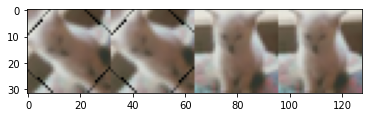

In [28]:
plt.imshow(
    np.hstack(
        [
         rotated[0].numpy().astype(np.int64),
         flip2[0].numpy().astype(np.int64),
         fliped[0].numpy().astype(np.int64),
         x_train[922]
        ]
        )
)

In [29]:
# resize_layer = tf.keras.layers.experimental.preprocessing.Resizing(224,224)
# rotate_layer = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
# flip_layer = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal')

# layer 블락을 만드는 과정. 2~3번 과정으로 볼 수 있다. 
data_preprocessing = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224,224),
     tf.keras.layers.experimental.preprocessing.Rescaling(1./225.0),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal')]
)

In [30]:
processed = data_preprocessing(image)

In [31]:
processed.shape

TensorShape([1, 224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


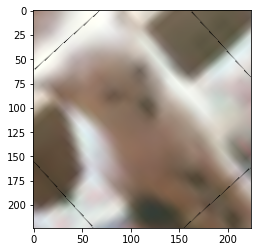

In [32]:
plt.imshow(processed[0].numpy())

In [33]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),
                                         weights = 'imagenet',
                                         include_top =False)
# include_top = fully connected 옵션 flatten , dense 와 같은(마지막 layer) 작업의 포함 유무.

58892288/58889256 [==============================] - 1s 0us/step


In [34]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [35]:
base_model.trainable = False # 가중치에 영향을 안받게 하기 위함..?

In [38]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [42]:
pre_test=data_preprocessing(x_test[:5])
pre_test2=base_model(pre_test)

In [41]:
pre_test.shape

TensorShape([5, 224, 224, 3])

In [43]:
pre_test2.shape

TensorShape([5, 7, 7, 512])

In [44]:
pre_test3 = tf.keras.layers.GlobalAveragePooling2D()(pre_test2) # 7X7 의 대표값을 하나 뽑아낸다.

In [45]:
pre_test3.shape 

TensorShape([5, 512])

In [46]:
output_layers = tf.keras.models.Sequential([ 
                                            tf.keras.layers.GlobalAveragePooling2D(),
                                            tf.keras.layers.Dense(200,activation='relu'),
                                            tf.keras.layers.Dense(10,activation='softmax')
])

In [50]:
# 엮어서 사용할 때 사용하는 클래스.
inputs = tf.keras.Input(shape=(32,32,3))


In [51]:
x=data_preprocessing(inputs)
x = base_model(x)
outputs = output_layers(x)
# Model class 는 input,output을 지정해주면, 연결을 시켜준다.
model = tf.keras.Model(inputs,outputs)

In [52]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
sequential_4 (Sequential)    (None, 10)                104610    
Total params: 14,819,298
Trainable params: 104,610
Non-trainable params: 14,714,688
_________________________________________________________________


In [53]:
test_result = model(x_test[:5])

In [54]:
test_result.shape

TensorShape([5, 10])

In [57]:
np.argmax(test_result,axis=1)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train,y_train,epochs=3)

Epoch 1/3
1563/1563 [==============================] - 209s 134ms/step - loss: 1.6558 - accuracy: 0.4086
Epoch 2/3
1563/1563 [==============================] - 207s 132ms/step - loss: 1.4072 - accuracy: 0.4994
Epoch 3/3
1563/1563 [==============================] - 207s 132ms/step - loss: 1.3303 - accuracy: 0.5292
